In [148]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Méthode de la bissection #

In [149]:
def methode_bissection(f, a, b, tol=1e-8, max_iter=1000):
    fa = f(a)
    fb = f(b)

    if fa * fb >= 0:
        raise ValueError("f(a) et f(b) doivent avoir des signes opposés")

    for i in range(max_iter):
        m = (a + b) / 2
        fm = f(m)
        if abs(fm) < tol:
            return m, i+1
        if fm * fa < 0:
            b = m
        else:
            a = m
            fa = fm

    raise RuntimeError("Nombre d'itérations maximum atteint sans convergence")

    

# Méthode de la sécante #

In [150]:
def methode_secante(f, a, b, tol=1e-8, max_iter=1000):
    fa = f(a)
    fb = f(b)

    for i in range(max_iter):
        if fb == fa:
            raise ZeroDivisionError("Les points initiaux doivent être différents")

        # Formule de la sécante
        s = b - fb * ((b-a)/(fb-fa))
        fs = f(s)

        if abs(fs) < tol:
            return s, i+1  # Racine trouvée

        # Mise à jour des variables pour l'itération suivante
        a, fa = b, fb
        b, fb = s, fs

    return s

# Méthode de la sécante #

In [151]:
def methode_dekker(f, a, b, tol=1e-8, max_iter=1000):
    fa = f(a)
    fb = f(b)

    if f(a) * f(b) >= 0:
        raise Exception("Les valeurs aux bornes choisies ne sont pas de signes opposés")
    
    # Échange a et b, car b doit représenté la meilleure approximation de la racine
    if abs(fa) < abs(fb):
        a, b = b, a
        fa, fb = fb, fa

    # Définition variables
    c = a 
    fc = fa
    
    for i in range(max_iter):
        # Calcul de s avec la méthode de la sécante
        s = b - fb * ((b-c)/(fb-fc))
         
        # Calcul de m avec la méthode de bissection
        m = (a + b) / 2
        
        # Pour que s soit accepté, s doit se trouver entre m et b, aussi non on utilise m
        if (s-b)*(s-m) >= 0:
            s = m
        
        fs = f(s)
        if abs(fs) < tol:
            return s, i+1
        
        # Définir b_k-1
        c = b
        fc = fb

        # Choix du nouveau contrepoint afin que f(a+1) et f(b+1) soient de signes opposés
        if fa * fs < 0:
            b = s
            fb = fs
        else:
            a = s
            fa = fs

        # S'assure que b est la meilleure approximation de la racine
        if abs(fa) < abs(fb):
            a, b = b, a
            fa, fb = fb, fa
        

    raise RuntimeError("Nombre d'itérations maximum atteint sans convergence")

# Méthode de Brent #

In [152]:
def methode_brent(f, a, b, tol=1e-8, max_iter=1000):
    fa = f(a)
    fb = f(b)

    if f(a) * f(b) >= 0:
        raise Exception("Les valeurs aux bornes choisies ne sont pas de signes opposés")
    
    # Échange a et b, car b doit représenté la meilleure approximation de la racine
    if abs(fa) < abs(fb):
        a, b = b, a
        fa, fb = fb, fa

    # Définition variables
    c = b 
    fc = b
    d = 0
    
    # Paramètre déterminant si la méthode de dichotomie ou d'interpolation a été retenue précédemment
    dicho = True

    for i in range(max_iter):
        # Calcul de s avec interpolation quadratique inverse ou avec méthode des sécantes
        if fa != fb and fa != fc and fb != fc:
            s = (a*fb*fc)/((fa-fb)*(fa-fc)) + (b*fa*fc)/((fb-fa)*(fb-fc)) + (c*fa*fb)/((fc-fa)*(fc-fb)) 
        else:
            s = b - fb * ((b-a)/(fb-fa))
         
        # Conditions pour utiliser le point milieu calculé avec la méthode de dichotomie plutôt que s calculé avec l'interpolation
        # Certaines conditions dépendent de la méthode utilisée à l'itération précedente soit le paramètre dicho
        cond1 = (s - (3*a + b)/4)*(s - b) >= 0
        cond2 = dicho and abs(s - b) >= 0.5*abs(b - c)
        cond3 = not dicho and abs(s - b) >= 0.5*abs(c - d)
        
        if cond1 or cond2 or cond3:
            s = (a + b)/2
            dicho = True
        else:
            dicho = False

        fs = f(s) 
        if abs(fs) < tol: # Racine trouvée
            return s, i+1 

        # Modification variable pour prochaine itération
        d = c
        c = b
        fc = fb
        
        # Choix du nouveau contrepoint afin que f(a+1) et f(b+1) soient de signes opposés
        if fa * fs < 0:
            b = s
            fb = fs
        else:
            a = s
            fa = fs

        # S'assure que b est la meilleure approximation de la racine
        if abs(fa) < abs(fb):
            a, b = b, a
            fa, fb = fb, fa

    raise RuntimeError("Nombre d'itérations maximum atteint sans convergence")

In [153]:
def f(x):
    return x**3 - x - 2

def g(x):
    return np.tan(x)-x

# Test de la méthode sur [1, 2] avec une tolérance de 1e-8
racine_approx = methode_brent(f, 1, 2, 1e-8)
a = methode_bissection(f, 1, 2, tol=1e-8)
b = methode_secante(f, 1, 2)
c = methode_dekker(f, 1, 2)
print(racine_approx)
print(a)
print(b)
print(c)

(1.521379706804822, 5)
(1.5213797055184841, 28)
(1.5213797079848717, 6)
(1.5213797068040897, 7)


[-2.15 -1.42 -1.29 -0.2   0.1   0.14  0.82  1.1   1.5   2.85  3.8 ]
[1.23350e-02 1.22439e-01 1.83396e-01 9.62973e-01 9.92804e-01 9.77224e-01
 5.23455e-01 2.93345e-01 1.05332e-01 3.94000e-04 1.40000e-06]


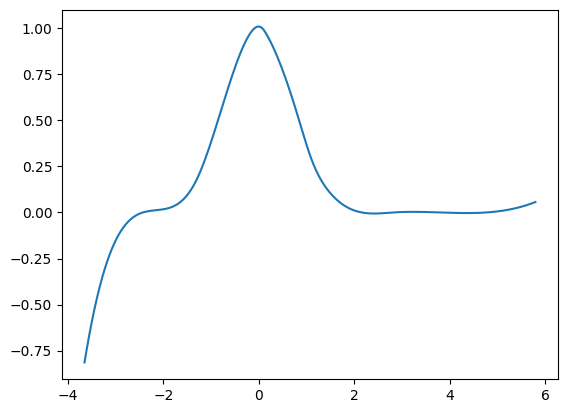

0.011116746888370808
(-2.4270444306146817, 6)
(-2.4270444545766168, 42)
(-2.4270444306146817, 6)
(-2.427044454599352, 8)
(-2.427044454599352, 8)


In [154]:
x = np.array([-2.15, -1.42, -1.29, -0.2, 0.1, 0.14, 0.82, 1.1, 1.5, 2.85, 3.8])
y = np.array([0.012335, 0.122439, 0.183396, 0.962973, 0.992804, 0.977224, 0.523455, 0.293345, 0.105332, 0.000394, 0.0000014])

x_interp = np.linspace(np.min(x)-1.5, np.max(x)+2, 200)
# Spline naturelle: bc_type="natural"
print(x)
print(y)
cubic_spline = CubicSpline(x, y, bc_type="natural")
print(cubic_spline)
plt.plot(x_interp, cubic_spline(x_interp))
plt.show()
print(cubic_spline(2))
print(methode_brent(cubic_spline, -3, -2))
print(methode_bissection(cubic_spline, -3, -2, tol=1e-14))
print(methode_brent(cubic_spline, -3, -2, tol=1e-8))
print(methode_secante(cubic_spline, -3, -2, tol=1e-8))
print(methode_dekker(cubic_spline, -3, -2, tol=1e-8))